# Inferance on [Breast Ultrasound Images Dataset](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset) dataset using Fine-tuned SAM.
1. Train the model using `train.py` or `train_no_npz.py` and save the checkpoints.

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Spacingd,
    ScaleIntensityRanged,
    ResizeWithPadOrCropd,
    ToTensord,
    RepeatChanneld,
    Resized,
)
from monai.data import CacheDataset
from utils.dataset import load_one_by_one
import json
from monai.data import DataLoader
from segment_anything import sam_model_registry
from tqdm import tqdm
import SimpleITK as sitk
import h5py
import os
join=os.path.join
import torch.nn.functional as F
from pathlib import Path
from utils.Transform import get_center_box

## 制作数据集

In [ ]:
# 把h5文件切片
slice_store_path = "/data3/home/lishengyong/data/ssc/slices/test_mask"
h5path = "/data2/home/zoulongkuan/lung_nodule/ssc/h5.files/nodules.list.rj.20230703.pred.h5"
def write(a, path, spacing=None):
    b = sitk.GetImageFromArray(a)
    if spacing is not None:
        b.SetSpacing(spacing[:-1])
    sitk.WriteImage(b, path)
for i in ["images", "masks"]:  #, "labels", "3D_images", "3D_masks"
    os.makedirs(os.path.join(slice_store_path, i), exist_ok=True)    
    
def section(i):    
    file = h5py.File(i, "r")
    for key in file.keys():
        print(key, file[key].shape)
    for j in range(len(file["centers"])):
        mask = file["masks"][j,..., 8]
        spacing = file["spacings"][j]
        single_store = slice_store_path + f"/images/{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz"
        if np.sum(mask) == 0:
            print(single_store)
            continue
        elif os.path.exists(single_store):
            continue
        write(mask, single_store.replace("images", "masks"))
        write(file["datas"][j,...,8], single_store)
        
    file.close()

# section(h5path)
        

In [1]:
# 生成json文件
import os
join = os.path.join
import json
slice_store_path = "/data3/home/lishengyong/data/ssc_3d/slices"
cases = os.listdir(slice_store_path+"/3D_images")
cases.sort()
test_list = []
for i in cases:
    single_dict = {
        "3D_image": slice_store_path+f"/3D_images/{i}",
        #"label": slice_store_path+f"/labels/{i}",
        "3D_mask": slice_store_path+f"/3D_masks/{i}"
    }
    test_list.append(single_dict)
print(len(test_list))
data = {"test":test_list} #"train": train_list, "validation":val_list, 
d = json.dumps(data)
with open(slice_store_path+"/dataset_3d.json", "w") as f:
    f.write(d)
    

100


In [12]:
with open(slice_store_path+"/dataset.json") as f:
    data = json.load(f)

print(len(data["test"]))
print(data["test"][3836*2:3836*3][:3])

15346
[{'image': '/data3/home/lishengyong/data/ssc_0802/new821/images/3091.nii.gz', 'mask': '/data3/home/lishengyong/data/ssc_0802/new821/masks/3091.nii.gz'}, {'image': '/data3/home/lishengyong/data/ssc_0802/new821/images/3092.nii.gz', 'mask': '/data3/home/lishengyong/data/ssc_0802/new821/masks/3092.nii.gz'}, {'image': '/data3/home/lishengyong/data/ssc_0802/new821/images/3093.nii.gz', 'mask': '/data3/home/lishengyong/data/ssc_0802/new821/masks/3093.nii.gz'}]


## Setting


In [4]:
model_type = "vit_b"
model_path = "0730_1845"
checkpoint = f'/data3/home/lishengyong/code/MedSAM/work_dir/new/ssc_{model_path}/sam_model_val_best.pth'
device = "cuda:1"
slice_store_path = "/data3/home/lishengyong/data/ssc/new_slices/aug"
data_path = slice_store_path+"/dataset.json"
embadding_store_path = join(slice_store_path, "center_embadding")



In [6]:

# 注册SAM
#sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model = sam_model_registry[model_type]().to(device)
info = torch.load(checkpoint)
my_dic_keys = list(info['state_dict'].keys())
for key in my_dic_keys:
    info['state_dict'][key.replace("module.", "")] = info['state_dict'].pop(key)
sam_model.load_state_dict(info['state_dict'])
# 创建文件夹
os.makedirs(embadding_store_path, exist_ok=True)

## Prepare the dataset

### transform

In [7]:

# 这里是有resize的
test_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "mask"]),  # 加载完xy会反调？
        EnsureChannelFirstd(keys=["image", "mask"]),
        EnsureTyped(keys=["image"], dtype=torch.float32),
        EnsureTyped(keys=["mask"], dtype=torch.long),
        # ScaleIntensityRangePercentilesd("image", 0.5, 99.5, 0, 255, True),
        # ScaleIntensityRanged("image", -1250, 500, 0, 255, True),
        get_center_box(),
        Resized("shifted_imgs", (1024, 1024), mode="bilinear"),
        RepeatChanneld("shifted_imgs", 3),
        ToTensord(keys=["shifted_imgs"], dtype=torch.float32)
    ])

/data3/home/lishengyong/anaconda3/envs/sam/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


### load data

In [8]:
with open(data_path) as f:
    data = json.load(f)

test_encoder_ds = CacheDataset(
    data=data["test"],
    transform=test_transform,
    cache_rate=0,
    num_workers=8,
)
test_encoder_dataloader = DataLoader(test_encoder_ds, batch_size=1, shuffle=False, num_workers=4)


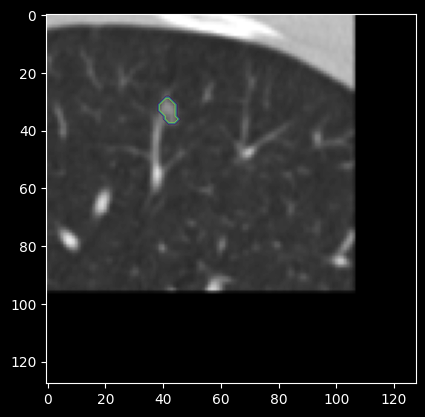

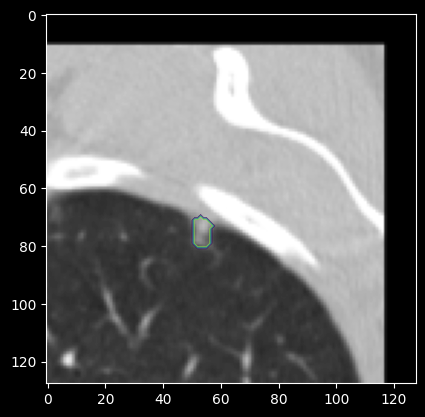

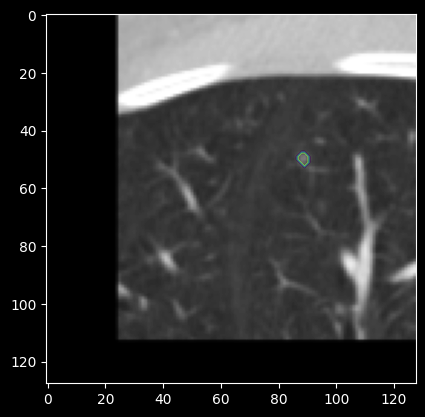

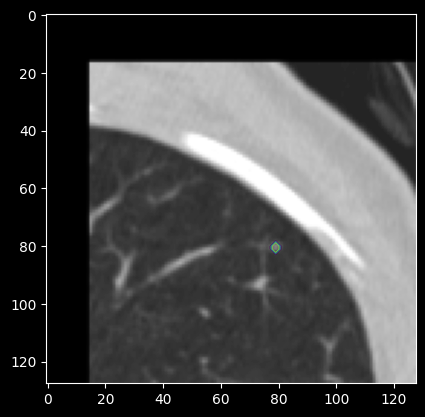

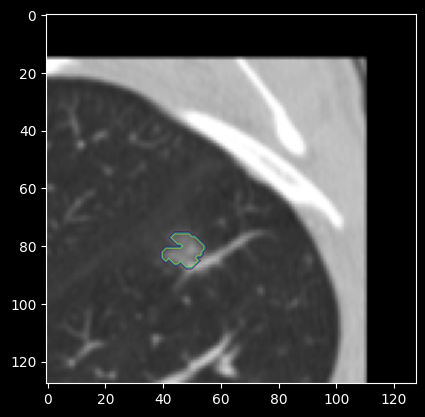

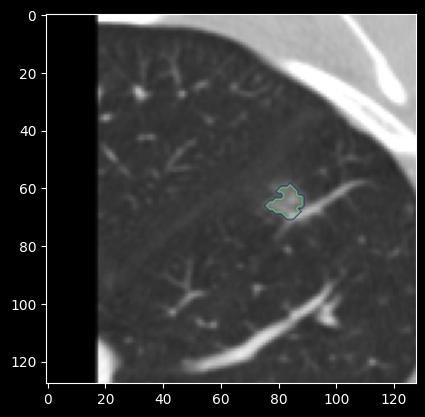

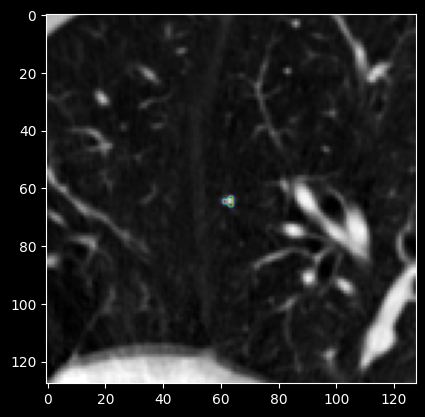

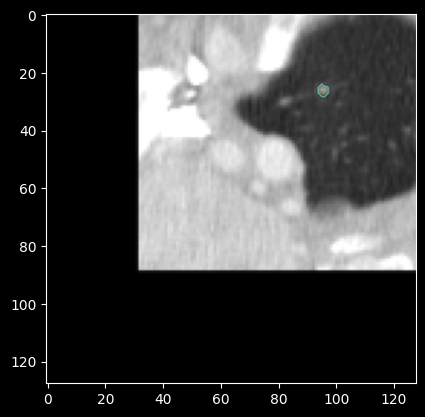

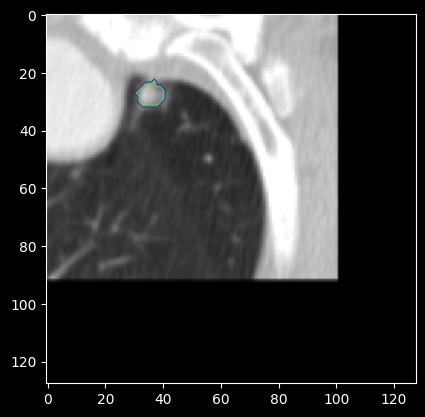

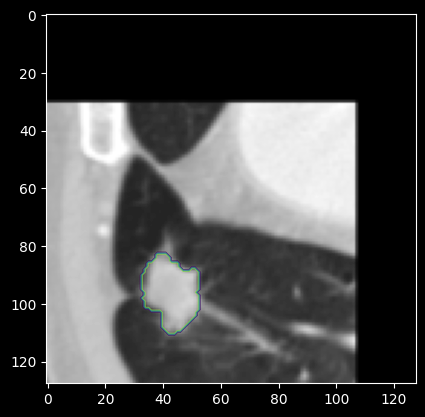

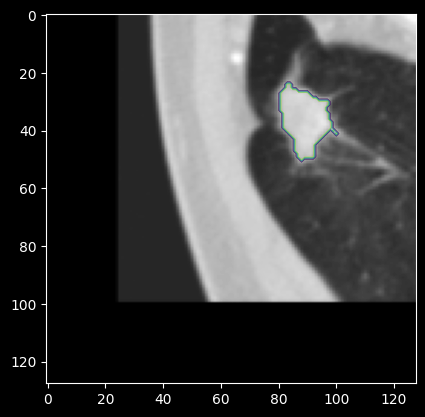

In [9]:

# display sample image and mask pairs in a given batch
def show_img_label(img_array, roi_array, show_index=None):
    # plt.clf()
    if show_index != None:
        show_img = img_array[show_index, ...]
        show_roi = roi_array[show_index, ...]
    else:
        show_img = img_array
        show_roi = roi_array
    # plt.axis('off')
    plt.imshow(show_img, cmap='gray')
    plt.contour(show_roi, linewidths=0.3)
    
k = 0  
for i in test_encoder_ds:
    k += 1
    show_img_label(i["image"], i["mask"], 0)
    plt.show()
    if k > 10:
        break

In [10]:
sam_model.eval()
with torch.no_grad():
    for step, batch_data in enumerate(tqdm(test_encoder_dataloader)):
        imgs, mask, centers, bboxes = (
                        batch_data["shifted_imgs"].to(device),
                        batch_data["mask"],
                        batch_data["centers"],
                        batch_data["bbox"],
                    )
        name = os.path.basename(mask[0].meta["filename_or_obj"][:-7])
        for number, bbox in enumerate(bboxes):
            image_embedding = sam_model.image_encoder(imgs[:,number*3:number*3+3,...])
            with h5py.File(embadding_store_path + f"/{name}_{number}.h5py", "w") as f:
                f["img_embedding"] = image_embedding[0, ...].cpu().numpy()
                f["bbox"] = torch.Tensor(bbox) 
                f["bbox_center"] = torch.Tensor(centers[number])



100%|██████████| 1517/1517 [08:00<00:00,  3.16it/s]


## Infer

### load img_embedding

In [13]:

from model.med_sam import prompter_network
from utils.Transform import Loadh5


In [15]:
sam_prompt = prompter_network(sam_model, True).to(device)
test_transform = Compose([
                    Loadh5(),
                    ToTensord(["img_embedding", "bbox"], torch.float32)
                ])
files = [i for i in Path(embadding_store_path).iterdir()]
val_dataset = CacheDataset(files, test_transform, 0, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=80, shuffle=False)

In [16]:
infer_path = slice_store_path+f"/infer/{model_path}"
os.makedirs(infer_path, exist_ok=True)
sam_model.eval()
with torch.no_grad():
    for step, batch_data in enumerate(tqdm(val_dataloader)):       
        image_embedding, bbox = (
            batch_data["img_embedding"].to(device),
            batch_data["bbox"].to(device)
            )
        sparse_embeddings, dense_embeddings = sam_prompt(bbox, None)
        medsam_seg_prob, _= sam_model.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        ori_res_masks = F.interpolate(
                medsam_seg_prob,
                size=(128, 128),
                mode="bilinear",
                align_corners=False,
                )
# convert soft mask to hard mask
        med_seg = (ori_res_masks > 0.5)
        for index in range(med_seg.shape[0]):
            seg_img = sitk.GetImageFromArray(med_seg[index, 0, ...].cpu().numpy().astype(np.int8))
            sitk.WriteImage(seg_img, join(infer_path, f"{batch_data['name'][index]}.nii.gz"))

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


In [7]:
def shift_mask(cropped_mask, shifts):
    coords = np.transpose(np.where(cropped_mask))  # Nx3
    coords += shifts  # coordinates transform original image
    # do clipping, in case of out of index error
    legal_index = np.logical_and((coords < 128).all(1), (coords > 0).all(1))  # 
    coords = coords[legal_index]
    return tuple(coords.T)

In [8]:
# 这一步检查一下center是大的mask的center还是小的mask的，7月的都是大的mask
infer_path = slice_store_path+f"/infer/{model_path}"
processed_infer_path = join(slice_store_path, f"infer/{model_path}_processed")
os.makedirs(processed_infer_path, exist_ok=True)
cases = os.listdir(slice_store_path+"/images")
cases = [i[:-7] for i in cases]
for case in tqdm(cases):
    sum_array = np.zeros((128, 128))
    for j in range(10):
        single_file_path = join(infer_path, f"{case}_{j}.nii.gz")
        if os.path.exists(single_file_path):
            roi = sitk.ReadImage(single_file_path)
            roi_arr = sitk.GetArrayFromImage(roi)
            # roi_arr = np.pad(roi_arr, ((128, 128), (128, 128)), "constant", constant_values=(0, 0))
            with h5py.File(single_file_path.replace(f"infer/{model_path}", "center_embadding").replace("nii.gz", "h5py"), "r") as file:
                # center = file[""]
                shift_size = file["bbox_center"][:] - 64
                coords = shift_mask(roi_arr, shift_size.astype("int64"))
            sum_array[coords] = 1
        else:
            break
    sum_array = np.clip(sum_array, 0, 1).T
    # plt.imshow(sum_array)
    # plt.show()
    case_roi = sitk.GetImageFromArray(sum_array)
    sitk.WriteImage(case_roi, join(processed_infer_path, case+".nii.gz"))
                

100%|██████████| 1517/1517 [00:05<00:00, 290.99it/s]


### 计算dice

In [11]:
# 计算DICE
from pathlib import Path
import SimpleITK as sitk
from utils.SurfaceDice import compute_dice_coefficient
infer_path = Path("/data3/home/lishengyong/data/ssc_0802/new_slices/infer/0807_onebox")
dices = []
for case in infer_path.iterdir():
    gt = sitk.ReadImage(case)
    pred = sitk.ReadImage(str(case).replace("infer/0807_onebox", "labels"))
    dice = compute_dice_coefficient(sitk.GetArrayFromImage(gt).astype(int), sitk.GetArrayFromImage(pred).astype(int))
    dices.append(dice)
print(sum(dices)/len(dices))

0.8753928764393054


In [ ]:
for case in tqdm(cases[:10]):
    roi = sitk.ReadImage(join(processed_infer_path, case+".nii.gz"))
    plt.imshow(sitk.GetArrayFromImage(roi))
    plt.show()

In [ ]:
roi_arrs = []
with h5py.File(h5path, 'r') as file:
    for j in range(len(file["centers"])): 
        single_store = join(processed_infer_path, f"{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz")
        if os.path.exists(single_store):
            roi = sitk.ReadImage(single_store)
            roi_arr = sitk.GetArrayFromImage(roi)
        else:
            roi_arr = np.zeros((128, 128))
            print(os.path.basename(single_store))
        roi_arrs.append(roi_arr)

roi = sitk.GetImageFromArray(np.stack(roi_arrs))
roi.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0))
sitk.WriteImage(roi, processed_infer_path+".nii.gz")

### show img

In [ ]:
def show_img_label(img_array, roi_array, show_index=None):
    # plt.clf()
    if show_index != None:
        show_img = img_array[show_index, ...]
        show_roi = roi_array[show_index, ...]
    else:
        show_img = img_array
        show_roi = roi_array
    # plt.axis('off')
    plt.imshow(show_img, cmap='gray')
    plt.contour(show_roi, linewidths=0.3)
    
def show_from_path(img_path, roi_path=None):
    size = "small"
    img = sitk.ReadImage(img_path)
    img_arr = sitk.GetArrayFromImage(img)
    if roi_path is not None:
        roi = sitk.ReadImage(roi_path)
        roi_arr = sitk.GetArrayFromImage(roi)
        if np.sum(roi_arr) >= 10:
            size = "big"   
    show_img_label(img_arr, roi_arr)
    return size
    
def show_mask_pred(img_path, mask_path, pred_path):
    plt.subplot(1,2,1)
    plt.title("mask before refine")
    size = show_from_path(img_path, mask_path)
    plt.subplot(1,2,2)
    plt.title("mask after refine")
    show_from_path(img_path, pred_path)
    return size
    

In [ ]:
from pathlib import Path
img_root = "/data3/home/lishengyong/data/ssc/new726/images"
mask_root = "/data3/home/lishengyong/data/ssc/new726/masks"
check_out_path = "/data3/home/lishengyong/data/ssc/2D_bbox/processed_data/zoom_rotate_726test/check_out"
os.makedirs(join(store_path, "check_out", "small"), exist_ok=True)
os.makedirs(join(store_path, "check_out", "big"), exist_ok=True)
# plt.figure(figsize=(16, 12))
for i in tqdm(cases[:1500]):
    case_name = i + ".nii.gz"
    size = show_mask_pred(join(img_root, case_name), join(mask_root, case_name), join(processed_infer_path, case_name))
    plt.savefig(join(check_out_path, size, i)+".png", dpi=300)
    plt.clf()
    plt.show()

In [5]:
# 拼成一个nii
import nibabel as nib
import h5py
import os
join = os.path.join
import numpy as np
processed_infer_path = "/data3/home/lishengyong/data/ssc/new726/infer/0818_98_processed"
roi_arrs = []
with h5py.File("/data2/home/zoulongkuan/lung_nodule/ssc/h5.files/lung_false_positive_batch2.4_marker_2021.0422.0623_tp.train.fix_bug_2022.9.22.txt.h5", 'r') as file:
    for j in range(len(file["centers"])): 
        single_store = join(processed_infer_path, f"{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz")
        if os.path.exists(single_store):
            roi_arr = nib.load(single_store).get_fdata()
        else:
            roi_arr = np.zeros((128, 128))
            print(os.path.basename(single_store))
        roi_arrs.append(roi_arr)

roi = nib.Nifti1Image(np.stack(roi_arrs, axis=2), None)
# roi.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0))
nib.save(roi, processed_infer_path+".nii.gz")
        

'1.3.12.2.1107.5.1.4.60211.3000002012160328346dd9UEwixvi9Qi4yiVbsejsgKU5ASPv.zarr'_[132 287  77].nii.gz
